Downloading...
From: https://drive.google.com/uc?export=download&id=1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE
To: /content/Customers.csv
100%|██████████| 8.54k/8.54k [00:00<00:00, 14.2MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1IKuDizVapw-hyktwfpoAoaGtHtTNHfd0
To: /content/Products.csv
100%|██████████| 4.25k/4.25k [00:00<00:00, 6.47MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF
To: /content/Transactions.csv
100%|██████████| 54.7k/54.7k [00:00<00:00, 56.8MB/s]


Davies-Bouldin Index: 1.540


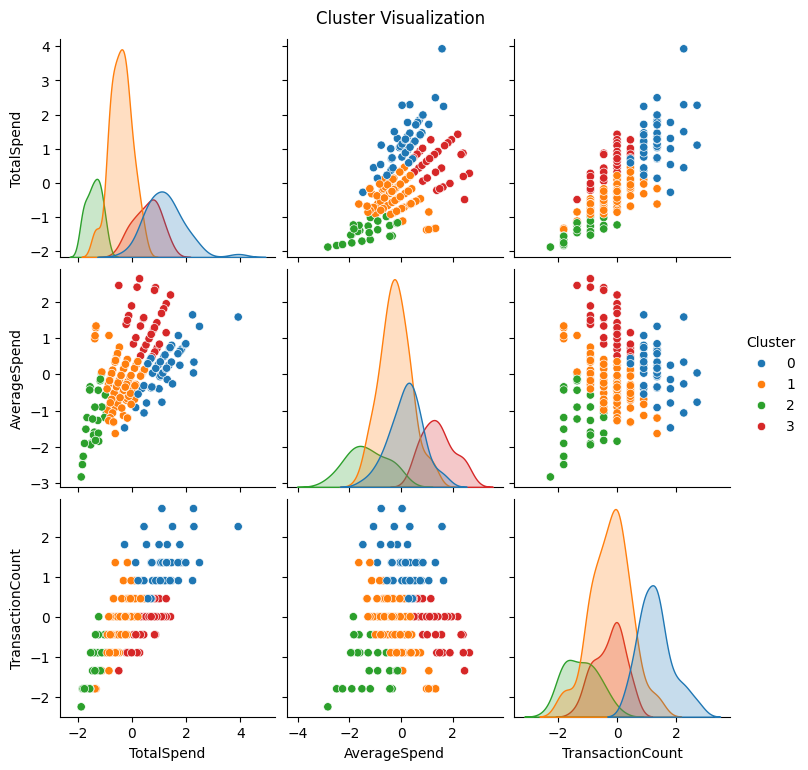


Clustering Results:
         TotalSpend  AverageSpend  TransactionCount  Region_Europe  \
Cluster                                                              
0          1.217754      0.191276          1.297469       0.145833   
1         -0.417387     -0.224920         -0.225647       0.206522   
2         -1.408851     -1.314395         -1.220164       0.333333   
3          0.545043      1.424245         -0.259836       0.454545   

         Region_North America  Region_South America  TopCategory_Books  \
Cluster                                                                  
0                    0.208333              0.354167           0.479167   
1                    0.271739              0.271739           0.282609   
2                    0.185185              0.333333           0.259259   
3                    0.181818              0.242424           0.333333   

         TopCategory_Clothing  TopCategory_Electronics  TopCategory_Home Decor  
Cluster                         

In [ ]:
!pip install gdown pandas scikit-learn

import pandas as pd
import gdown
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

urls = {
    "Customers.csv": "https://drive.google.com/uc?export=download&id=1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE",
    "Products.csv": "https://drive.google.com/uc?export=download&id=1IKuDizVapw-hyktwfpoAoaGtHtTNHfd0",
    "Transactions.csv": "https://drive.google.com/uc?export=download&id=1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF"
}

for filename, url in urls.items():
    gdown.download(url, filename, quiet=False)

customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

transactions_products = pd.merge(transactions, products, on="ProductID", how="left")
customer_features = transactions_products.groupby("CustomerID").agg({
    "TotalValue": ["sum", "mean", "count"],
    "Category": lambda x: x.mode()[0] if not x.mode().empty else "Unknown"
}).reset_index()

customer_features.columns = ["CustomerID", "TotalSpend", "AverageSpend", "TransactionCount", "TopCategory"]

customer_profiles = pd.merge(customers, customer_features, on="CustomerID", how="left")
customer_profiles.fillna(0, inplace=True)

customer_profiles = pd.get_dummies(customer_profiles, columns=["Region", "TopCategory"], drop_first=True)

numerical_columns = ["TotalSpend", "AverageSpend", "TransactionCount"]
scaler = StandardScaler()
customer_profiles[numerical_columns] = scaler.fit_transform(customer_profiles[numerical_columns])

X = customer_profiles[numerical_columns + [col for col in customer_profiles.columns if "Region_" in col or "TopCategory_" in col]]
kmeans = KMeans(n_clusters=4, random_state=42)
customer_profiles["Cluster"] = kmeans.fit_predict(X)

db_index = davies_bouldin_score(X, customer_profiles["Cluster"])
print(f"Davies-Bouldin Index: {db_index:.3f}")

sns.pairplot(customer_profiles, vars=["TotalSpend", "AverageSpend", "TransactionCount"], hue="Cluster", palette="tab10")
plt.suptitle("Cluster Visualization", y=1.02)
plt.show()

numeric_columns = ["TotalSpend", "AverageSpend", "TransactionCount"] + [col for col in customer_profiles.columns if "Region_" in col or "TopCategory_" in col]
clustering_summary = customer_profiles.groupby("Cluster")[numeric_columns].mean()

print("\nClustering Results:")
print(clustering_summary)

customer_profiles.to_csv("Customer_Clusters.csv", index=False)
print("\nClustered customer profiles saved as 'Customer_Clusters.csv'.")
